# Persistence Images in Classification

This notebook shows how you can use persistent homology and persistence images to classify datasets.  We construct datasets from two classes, one just noise and the other noise with a big circle in the middle. We then compute persistence diagrams with [Ripser.py](https://github.com/scikit-tda/ripser.py) and convert them to persistence images with [PersIm](https://github.com/scikit-tda/persim). Using these persistence images, we build a Logistic Regression model using a LASSO penatly to classify whether the dataset has a circle or not.  We find, using only default values, classification has a mean accuracy greater than 90.

In [1]:
import numpy as np
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from ripser import Rips
from persim import PersImage
from persim import PersistenceImager

## Construct data

Generate N datasets that are just noise and N that are noise with a circle. 

In [2]:
N = 200
N_per_class = int(N / 2)
N_in_class = 400

def noise(N, scale):
    return scale * np.random.random((N, 2))

def circle(N, scale, offset):
    return offset + scale * datasets.make_circles(n_samples=N, factor=0.4, noise=0.05)[0]
    
just_noise = [noise(N_in_class, 150) for _ in range(N_per_class)]

half = int(N_in_class / 2)
with_circle = [np.concatenate((circle(half, 50, 70), noise(half, 150)))
               for _ in range(N_per_class)]

datas = []
datas.extend(just_noise)
datas.extend(with_circle)

# Define labels
labels = np.zeros(N)
labels[N_per_class:] = 1

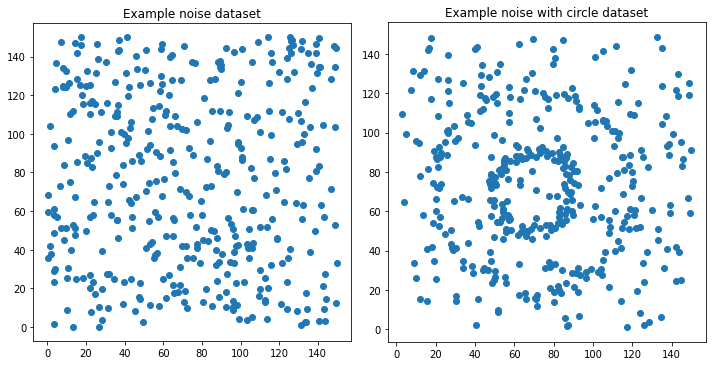

In [3]:
# Visualize the data
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(10,5)

xs, ys = just_noise[0][:,0], just_noise[0][:,1]
axs[0].scatter(xs, ys)
axs[0].set_title("Example noise dataset")
axs[0].set_aspect('equal', 'box')

xs_, ys_ = with_circle[0][:,0], with_circle[0][:,1]
axs[1].scatter(xs_, ys_)
axs[1].set_title("Example noise with circle dataset")
axs[1].set_aspect('equal', 'box')

fig.tight_layout()

## Compute homology of each dataset

Generate the persistence diagram of $H_1$ for each of the datasets generated above.

In [4]:
rips = Rips(maxdim=1, coeff=2)
diagrams = [rips.fit_transform(data) for data in datas]
diagrams_h1 = [rips.fit_transform(data)[1] for data in datas]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


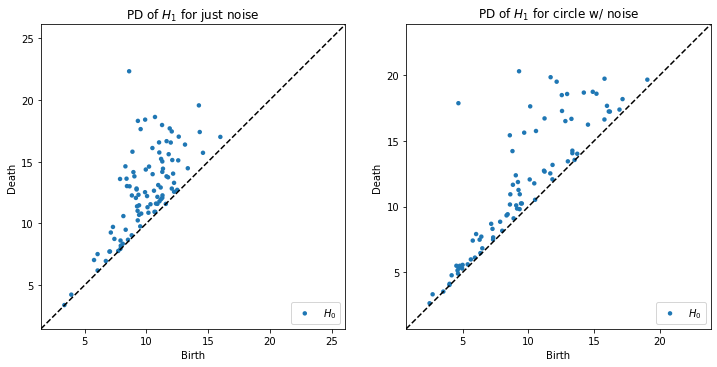

In [5]:
plt.figure(figsize=(12,6))
plt.subplot(121)

rips.plot(diagrams_h1[0], show=False)
plt.title("PD of $H_1$ for just noise")

plt.subplot(122)
rips.plot(diagrams_h1[-1], show=False)
plt.title("PD of $H_1$ for circle w/ noise")

plt.show()

## Compute persistence images

Convert each persistence diagram into a persistence image. Flatten each image into a vector format

In [6]:
pimgr = PersistenceImager(pixel_size=1)
pimgr.fit(diagrams_h1)
imgs = pimgr.transform(diagrams_h1)

In [7]:
pimgr

PersistenceImager object: 
  pixel size: 1 
  resolution: (36, 24) 
  birth range: (0.418421, 36.4184) 
  persistence range: (-0.164762, 23.8352) 
  weight: persistence 
  kernel: bvncdf 
  weight parameters: {n: 1.0} 
  kernel parameters: {sigma: [[1. 0.]
 [0. 1.]]}

In [8]:
imgs_array = np.array([img.flatten() for img in imgs])

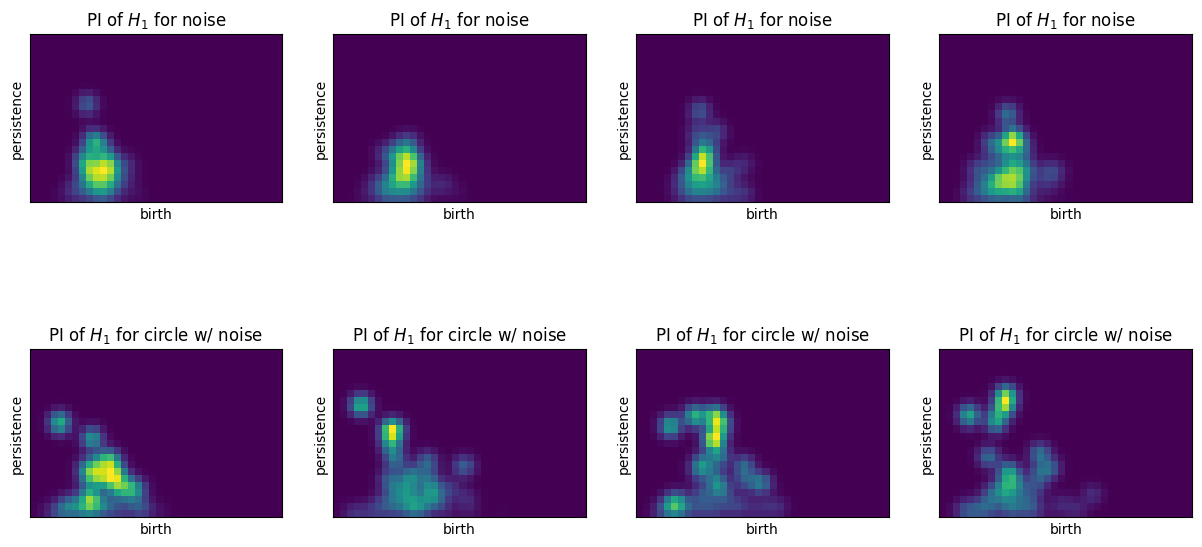

In [9]:
plt.figure(figsize=(15,7.5))

for i in range(4):
    ax = plt.subplot(240+i+1)
    pimgr.plot_image(imgs[i], ax)
    plt.title("PI of $H_1$ for noise")

for i in range(4):
    ax = plt.subplot(240+i+5)
    pimgr.plot_image(imgs[-(i+1)], ax)
    plt.title("PI of $H_1$ for circle w/ noise")

## Classify the datasets from the persistence images

In [10]:
X_train, X_test, y_train, y_test = train_test_split(imgs_array, labels, test_size=0.40, random_state=42)

In [11]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [12]:
lr.score(X_test, y_test)

1.0

So these are perfectly descriminative? Seems almost too good to be true. Let's see what features are important.

## Inverse analysis on LASSO 

Visualizing the regression coefficients as a persistence image shows us which features of the images are most important for classification.

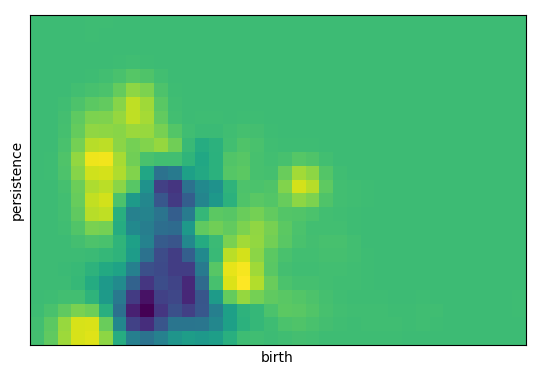

In [13]:
inverse_image = np.copy(lr.coef_).reshape(pimgr.resolution)
pimgr.plot_image(inverse_image)